In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import json

events_file = open('./router_events.log', 'r')
events = json.load(events_file)

<Container object of 41 artists>

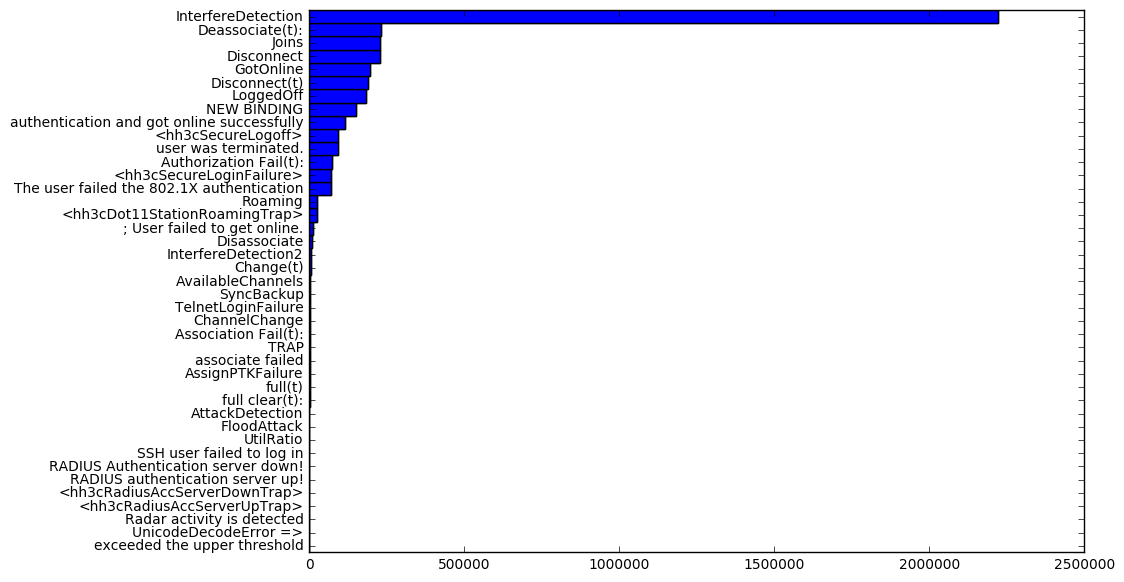

In [22]:
# plot a bar chart show the occurence of all events
filtered = events.items()
# filtered = filter(lambda x: not 'InterfereDetection' in x[0], events.items())
counts = sorted([(k, v['count']) for k, v in filtered], key=lambda x: x[1])

# zip(*list_of_tuples) == unzip(list_of_tuples)
bar_chart_labels, bar_chart_data = zip(*counts)

fig = plt.figure(figsize=(10, 7))

# plot a horizontal bar chart
plt.barh(np.arange(len(bar_chart_data)) + 5, bar_chart_data, tick_label=bar_chart_labels, height=1, align='center')

# little hack to expand the graph
plt.barh(np.arange(len(bar_chart_data)) + 5, bar_chart_data, tick_label=bar_chart_labels, height=1, align='center')

In [20]:
# aggregate the data of events count according to the apid

# apid to all events counts needed
apid_obj = {} 

# labels to be generated
active_event_labels = []
for event_name, event_obj in events.items():
    if len(event_obj['matches']) > 0:
        for match_name, match_obj in event_obj['matches'].items():
            if not 'apid' in match_name:
                continue
            label = (event_name + "." + match_name).replace(' ', '-')
            active_event_labels.append(label)
            print("Processing " + label + "...")
            for apid, count in match_obj.items():
                if not apid in apid_obj:
                    apid_obj[apid] = {"total_count":0}
                
                if label in apid_obj[apid]:
                    apid_obj[apid][label] += count
                else:
                    apid_obj[apid][label] = count
                    
                apid_obj[apid]["total_count"] += count

Processing Joins.apid...
Processing Roaming.apid_to...
Processing Roaming.apid_from...


291
[13230, 12873, 10978, 9450, 7948, 8134, 8225, 5802, 5097, 4586, 4330, 3953, 3568, 3035, 2414, 2270, 2000, 1736, 2131, 2397]
20
[1258, 1204, 751, 858, 964, 793, 621, 337, 471, 279, 178, 412, 480, 258, 327, 312, 448, 535, 231, 101]
20
[821, 759, 860, 708, 886, 761, 567, 480, 379, 442, 273, 362, 566, 352, 308, 367, 408, 539, 237, 91]
20


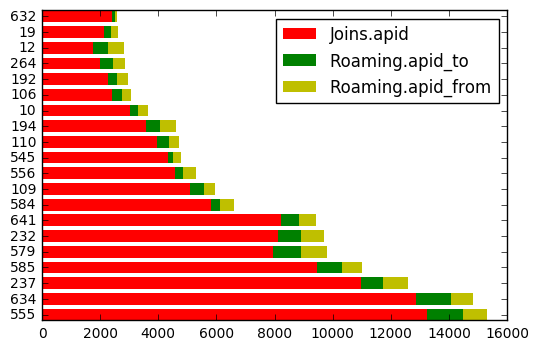

In [21]:
# plot the stacked bar chart showing some basic events
# for now => joins, roamed from, roamed to

# process the data for stacked bar
# we need 3 set of data for bar chart to plot the stacked bar

# sort the data by the total count, descending
apid_count_sorted = sorted(apid_obj.items(), key=lambda x: x[1]["total_count"], reverse=True)

# limit the data
apid_count_sorted_limited = apid_count_sorted[:20]
print(len(apid_count_sorted))
#print(apid_count_sorted_limited)

num_of_bars = len(active_event_labels)

# prepare the data for the stacked bar chart
stacked_bar_labels = []
stacked_bar_data_dict = {}

for label in active_event_labels:
    stacked_bar_data_dict[label] = []

for apid, count_dict in apid_count_sorted_limited:
    stacked_bar_labels.append(apid)
    
    for label in active_event_labels:
        if label in count_dict:
            stacked_bar_data_dict[label].append(count_dict[label])
        else:
            stacked_bar_data_dict[label].append(0)

#print()
#print(stacked_bar_data_dict)

# plot the stacked bar
last_left = [0] * len(stacked_bar_labels)
# print(last_left)
colors = ['r', 'g', 'y', 'b']
# height = 1. / (1 + len(stacked_bar_labels))
for index, label in enumerate(active_event_labels):
    print(stacked_bar_data_dict[label])
    plt.barh(np.arange(len(stacked_bar_labels)),
             stacked_bar_data_dict[label], height=0.75,
             tick_label=stacked_bar_labels, linewidth=0,
             left=last_left, align='center', color=colors[index])
    last_left = [x + y for x, y in zip(stacked_bar_data_dict[label], last_left)]
    print(len(last_left))

plt.legend(active_event_labels)

In [6]:
%matplotlib notebook

# draw the client flow

import networkx as nx
import matplotlib.patches as mpatches

241
264


<IPython.core.display.Javascript object>


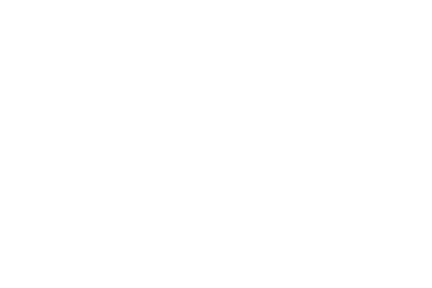

<IPython.core.display.Javascript object>


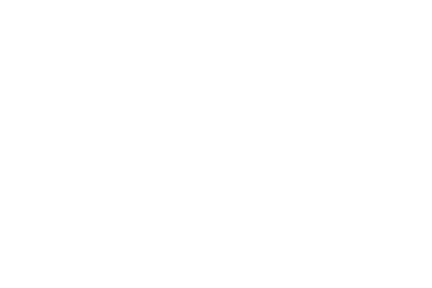

In [7]:
with open('./client_route.log') as route_file:
  paths = []
  for line in route_file:
    filter_seq = list(filter(lambda x: not 'dis' in x, line.split(':')[1].split(',')))
    #print(filter_seq)
    clean_seq = list(map(lambda x: x if not '\n' in x else x.replace('\n', ''), filter_seq))
    if len(clean_seq) > 2:
      #print(clean_seq)
      paths.append(clean_seq)

  print(len(paths))

  # to choose how many routes to be computed
  work_paths = paths
  #print(work_paths)
  graph = nx.DiGraph()

  # to store the value that would be drawed by networkx
  path_dict = {}
  for p in work_paths:
    tmp_n = ''
    for n in p:
      if tmp_n != '' and tmp_n != n:
        if not tmp_n in path_dict:
          path_dict[tmp_n] = {}
        if not n in path_dict[tmp_n]:
          path_dict[tmp_n][n] = 0
        path_dict[tmp_n][n] += 1
      tmp_n = n

  #print(path_dict)
  for k, v in path_dict.items():
    for vk, vv in v.items():
      graph.add_edge(k, vk, weight=vv)

  print(len(graph))

  fig = plt.figure()
  ax_graph = fig.add_subplot(111)

  default_node_color = '#95D47A'

  # generic graph drawing function
  # params:
  # legend - a list containing tuple as (color, label)
  def draw_graph(graph, ax, legend=[(default_node_color, 'APID')],
    with_labels=True, node_color=default_node_color,
    pos=nx.spring_layout(graph), **kwargs):
    # clean the graph
    ax.cla()
    nx.draw(graph, ax=ax, with_labels=with_labels, pos=pos, node_color=node_color, **kwargs)
    # activate the picker for all the artists in the graph
    for _artist in ax.findobj():
      _artist.set_picker(True)

    # print(ax.get_legend_handles_labels())
    if not legend is None:
      plt.legend(handles=list(map(lambda x: mpatches.Patch(color=x[0], label=x[1]), legend)))
    plt.draw()

  active_value = ""
  node_color_config = {
    'previous': '#B21F35',
    'current': '#FF7435',
    'next': '#FFCB35',
    'other': '#DFDFDF'
  }

  edge_color_config = {
    'previous-current': '#D82735',
    'current-next': '#FFA135',
    'other': '#DFDFDF'
  }

  # the length of this config would be the number of cycle colored
  cycle_color_config = [
    '#EF3E5B',
    # '#4B256D',
    # '#3F647E'
  ]

  # callback called when any artist is picked
  def onpick(event):
    name = type(event.artist).__name__
    global active_value
    if name is 'Text':
      value = event.artist.get_text()
      if value is active_value:
        # draw the default graph
        draw_default_graph()
        active_value = ""
      else:
        # draw the route graph for specific node
        active_value = value
        print("change color for " + value)
        
        prev_values = graph.predecessors(value)
        next_values = graph.successors(value)

        prev_edges = graph.in_edges(value)
        next_edges = graph.out_edges(value)

        draw_graph(graph, ax=ax_graph,
          node_color=list(map(lambda x: 
            node_color_config['previous'] if x in prev_values else
            node_color_config['current'] if x is value else 
            node_color_config['next'] if x in next_values else 
            node_color_config['other'], graph.nodes()
          )),
          edge_color=list(map(lambda x: 
            edge_color_config['previous-current'] if x in prev_edges else
            edge_color_config['current-next'] if x in next_edges else
            edge_color_config['other'], graph.edges()
          )),
          legend=(list(map(lambda x: (x[1], x[0]), node_color_config.items())))
        )

  def draw_default_graph():
    draw_graph(graph, ax=ax_graph)
    
  draw_default_graph()

  fig.canvas.mpl_connect('pick_event', onpick)
  fig.subplots_adjust(left=0, right=1.0, bottom=0, top=1.0)

#   plt.show()